In [2]:
%reload_ext autoreload
%autoreload 2

In [75]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

from EVO import LogisticRegression, EvolutionOptimizer, GradientDescentOptimizer, MultiClassLogisticRegressionWrapper



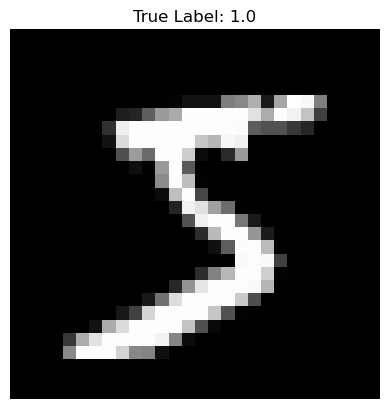

X_train_exp shape: torch.Size([60000, 7850])


In [81]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define a transform that converts images to a tensor and flattens them.
transform = transforms.Compose([
    transforms.ToTensor(),                    # MNIST images are [1, 28, 28]
    transforms.Lambda(lambda x: x.view(-1))     # Flatten to [784]
])

# Load the MNIST training and test sets.
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def add_bias(X):
    # X is of shape (N, 784), append a column of ones to yield shape (N, 785)
    N = X.size(0)
    bias = torch.ones(N, 1)
    return torch.cat([X, bias], dim=1)

# Build full training tensors.
X_train = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
X_train = add_bias(X_train)  # Now shape: (N_train, 785)
y_train = torch.tensor([float(train_dataset[i][1] > 4) for i in range(len(train_dataset))])

# Build full test tensors.
X_test = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
X_test = add_bias(X_test)   # Now shape: (N_test, 785)
y_test = torch.tensor([float(test_dataset[i][1] > 4) for i in range(len(test_dataset))])

def expand_features(X, num_classes=10):
    """
    Expand features from shape (N, d) to (N, d * num_classes) by forming blocks.
    Here we multiply each block by a unique constant so that each block is distinct.
    """
    N, d = X.shape
    blocks = []
    for c in range(num_classes):
        # Multiply the original features by (c+1)
        blocks.append( (c+1) * X )
    return torch.cat(blocks, dim=1)

# Expand the feature matrices so that each sample now has 7850 features.
X_train_exp = expand_features(X_train, num_classes=10)  # shape: (N_train, 7850)
X_test_exp  = expand_features(X_test, num_classes=10)   # shape: (N_test, 7850)

# (Optional) Visualize one original image.
img = X_train[0][:-1].view(28, 28)  # exclude bias from visualization
plt.imshow(img, cmap='gray')
plt.title(f"True Label: {y_train[0].item()}")
plt.axis('off')
plt.show()

print("X_train_exp shape:", X_train_exp.shape)  # Should be (N_train, 7850)

In [ ]:
import torch

# Choose device: use MPS if available (Apple Silicon), else CPU.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# Instantiate the model on the chosen device.
model = LogisticRegression()

# Import your EvolutionOptimizer from EVO.py (unchanged).
from EVO import EvolutionOptimizer

# Instantiate the evolutionary optimizer.
optimizer = EvolutionOptimizer(model)
optimizer.set_population_size(100)
optimizer.set_mutation_rate(0.2)
optimizer.set_mutation_intensity(0.6)
optimizer.set_diversity_coeff(1)
model.set_optimizer(optimizer)

# Ensure your expanded training data is on the same device.
X_train_exp = X_train_exp.to(device)   # X_train_exp should have shape (N_train, 7850)
y_train = y_train.to(device)

num_epochs = 2000
losses = []
train_accs = []

for epoch in range(num_epochs):
    optimizer.step(X_train_exp, y_train)
    
    # Compute the current loss and accuracy on the training set.
    loss_val = model.loss(X_train_exp, y_train).item()
    losses.append(loss_val)
    
    preds = model.predict(X_train_exp)
    acc = (preds == y_train).float().mean().item() * 100
    train_accs.append(acc)
    
    print(f"Epoch {epoch+1:02d}: Loss = {loss_val:.4f}, Training Accuracy = {acc:.2f}%")

Using device: mps
Epoch 01: Loss = -40.9528, Training Accuracy = 49.01%
Epoch 02: Loss = -50.8065, Training Accuracy = 49.01%
Epoch 03: Loss = -59.2382, Training Accuracy = 49.01%
Epoch 04: Loss = -66.4919, Training Accuracy = 49.01%
Epoch 05: Loss = -73.2193, Training Accuracy = 49.01%
Epoch 06: Loss = -79.4827, Training Accuracy = 49.01%
Epoch 07: Loss = -84.9124, Training Accuracy = 49.01%
Epoch 08: Loss = -90.0266, Training Accuracy = 49.01%
Epoch 09: Loss = -94.6126, Training Accuracy = 49.01%
Epoch 10: Loss = -99.1451, Training Accuracy = 49.01%
Epoch 11: Loss = -103.4172, Training Accuracy = 49.01%
Epoch 12: Loss = -107.3219, Training Accuracy = 49.01%
Epoch 13: Loss = -110.7140, Training Accuracy = 49.01%
Epoch 14: Loss = -114.2636, Training Accuracy = 49.01%
Epoch 15: Loss = -117.6671, Training Accuracy = 49.01%
Epoch 16: Loss = -120.5111, Training Accuracy = 49.01%
Epoch 17: Loss = -123.5587, Training Accuracy = 49.01%
Epoch 18: Loss = -126.6956, Training Accuracy = 49.01%
Ep

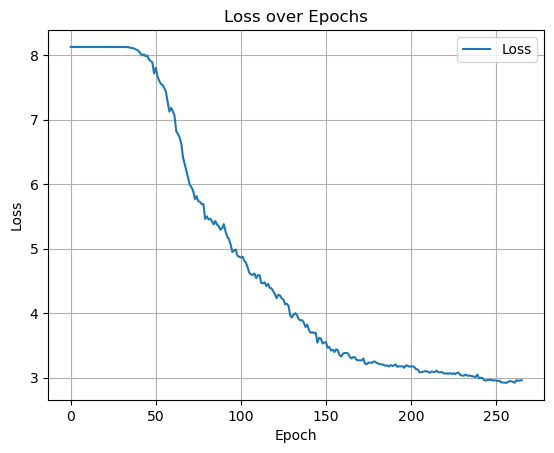

In [121]:
import matplotlib.pyplot as plt

# Plot the losses over epochs
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [117]:
def average_pairwise_distance(population):
    n = len(population)
    total_dist = 0
    count = 0

    for i in range(n):
        for j in range(i + 1, n):
            dist = torch.norm(population[i] - population[j])
            total_dist += dist
            count += 1

    return total_dist / count if count > 0 else 0

average_pairwise_distance(optimizer.population)

tensor(157.2024, device='mps:0')

In [ ]:
import torch

# List to collect predictions from every candidate in the population.
pop_predictions = []

# Loop over each candidate weight vector in the optimizer's population.
for candidate in optimizer.population:
    # Compute scores using the candidate weight vector.
    scores = model.score_with(X_train_exp, candidate)
    # Obtain predictions (class indices, 0 to 9) by taking the argmax.
    preds = torch.argmax(scores, dim=1)  # shape: (N_train,)
    pop_predictions.append(preds.unsqueeze(0))  # add a new dimension for stacking

# Stack predictions to form a tensor of shape (pop_size, N_train)
pop_preds_tensor = torch.cat(pop_predictions, dim=0)

# Compute the mode on the CPU as a fallback.
majority_preds, _ = torch.mode(pop_preds_tensor.cpu(), dim=0)

# Move the majority predictions back to the device (optional).
majority_preds = majority_preds.to(X_train_exp.device)

# Compute majority vote accuracy.
majority_vote_accuracy = (majority_preds == y_train).float().mean().item() * 100
print(f"Majority Vote Accuracy on Training Set: {majority_vote_accuracy:.2f}%")

AttributeError: 'LogisticRegression' object has no attribute 'score_with'

In [16]:
def population_majority_vote_accuracy(model, X, y):
    """
    For each sample, collect predictions from all individuals in the population,
    take the majority vote, and compare to ground truth labels.
    """
    n = X.size(0)
    votes = torch.zeros((len(model.population), n))

    for i, w in enumerate(model.population):
        logits = X @ w
        preds = (logits > 0).float()
        votes[i] = preds

    # Sum over voters and apply majority rule (>50%)
    majority_preds = (votes.mean(dim=0) > 0.5).float()
    accuracy = (majority_preds == y).float().mean().item() * 100
    return accuracy

def average_pairwise_distance(population):
    n = len(population)
    total_dist = 0
    count = 0

    for i in range(n):
        for j in range(i + 1, n):
            dist = torch.norm(population[i] - population[j])
            total_dist += dist
            count += 1

    return total_dist / count if count > 0 else 0

In [ ]:
# --- Train with Evolutionary Optimizer ---
model = LogisticRegression()
optimizer = EvolutionOptimizer(model)
optimizer.set_population_size(50)
optimizer.set_mutation_rate(0.01)
optimizer.set_mutation_intensity(2)

best_accs = []
majority_accs = []
losses = []

for epoch in range(150):
    optimizer.step(X_train, y_train)

    # Accuracy from best model (model.w)
    y_hat_best = model.predict(X_train)
    acc_best = (y_hat_best == y_train).float().mean().item() * 100

    # Accuracy from majority vote
    acc_majority = population_majority_vote_accuracy(model, X_train, y_train)

    # Loss of best model
    current_loss = model.loss(X_train, y_train).item()

    # Store values
    best_accs.append(acc_best)
    majority_accs.append(acc_majority)
    losses.append(current_loss)

    print(f"Epoch {epoch+1:02d} - Loss: {current_loss:.4f} | Best Acc: {acc_best:.2f}% | Majority Vote Acc: {acc_majority:.2f}%")





Epoch 01 - Loss: 14.3147 | Best Acc: 9.84% | Majority Vote Acc: 9.84%
Epoch 02 - Loss: 14.2409 | Best Acc: 9.84% | Majority Vote Acc: 9.84%
Epoch 03 - Loss: 14.2358 | Best Acc: 9.84% | Majority Vote Acc: 9.84%
Epoch 04 - Loss: 14.1415 | Best Acc: 9.84% | Majority Vote Acc: 9.84%
Epoch 05 - Loss: 13.9552 | Best Acc: 9.93% | Majority Vote Acc: 9.84%
Epoch 06 - Loss: 13.8366 | Best Acc: 10.11% | Majority Vote Acc: 9.84%
Epoch 07 - Loss: 13.7735 | Best Acc: 10.14% | Majority Vote Acc: 9.84%
Epoch 08 - Loss: 13.6082 | Best Acc: 10.20% | Majority Vote Acc: 9.84%
Epoch 09 - Loss: 13.0851 | Best Acc: 13.85% | Majority Vote Acc: 9.84%
Epoch 10 - Loss: 12.8729 | Best Acc: 14.77% | Majority Vote Acc: 9.86%
Epoch 11 - Loss: 12.6154 | Best Acc: 15.81% | Majority Vote Acc: 10.68%
Epoch 12 - Loss: 12.1688 | Best Acc: 18.75% | Majority Vote Acc: 13.15%
Epoch 13 - Loss: 11.9527 | Best Acc: 19.26% | Majority Vote Acc: 15.37%
Epoch 14 - Loss: 11.4085 | Best Acc: 21.15% | Majority Vote Acc: 16.84%
Epoch 1

In [17]:
diversity = average_pairwise_distance(model.population)
print(f"Diversity: {diversity:.4f}")

# Accuracy of the best individual model
y_pred_best = model.predict(X_val)
acc_best = (y_pred_best == y_val).float().mean().item() * 100

# Accuracy of the ensemble via majority vote
acc_majority = population_majority_vote_accuracy(model, X_val, y_val)

# Display the results
print(f"Validation Accuracy - Best Model: {acc_best:.2f}%")
print(f"Validation Accuracy - Majority Vote: {acc_majority:.2f}%")


Diversity: 0.0000


NameError: name 'X_val' is not defined

In [26]:
def find_most_diverse_pair(population):
    max_dist = -1
    pair = (None, None)

    for i in range(len(population)):
        for j in range(i+1, len(population)):
            dist = torch.norm(population[i] - population[j])
            if dist > max_dist:
                max_dist = dist
                pair = (population[i], population[j])
    
    return pair

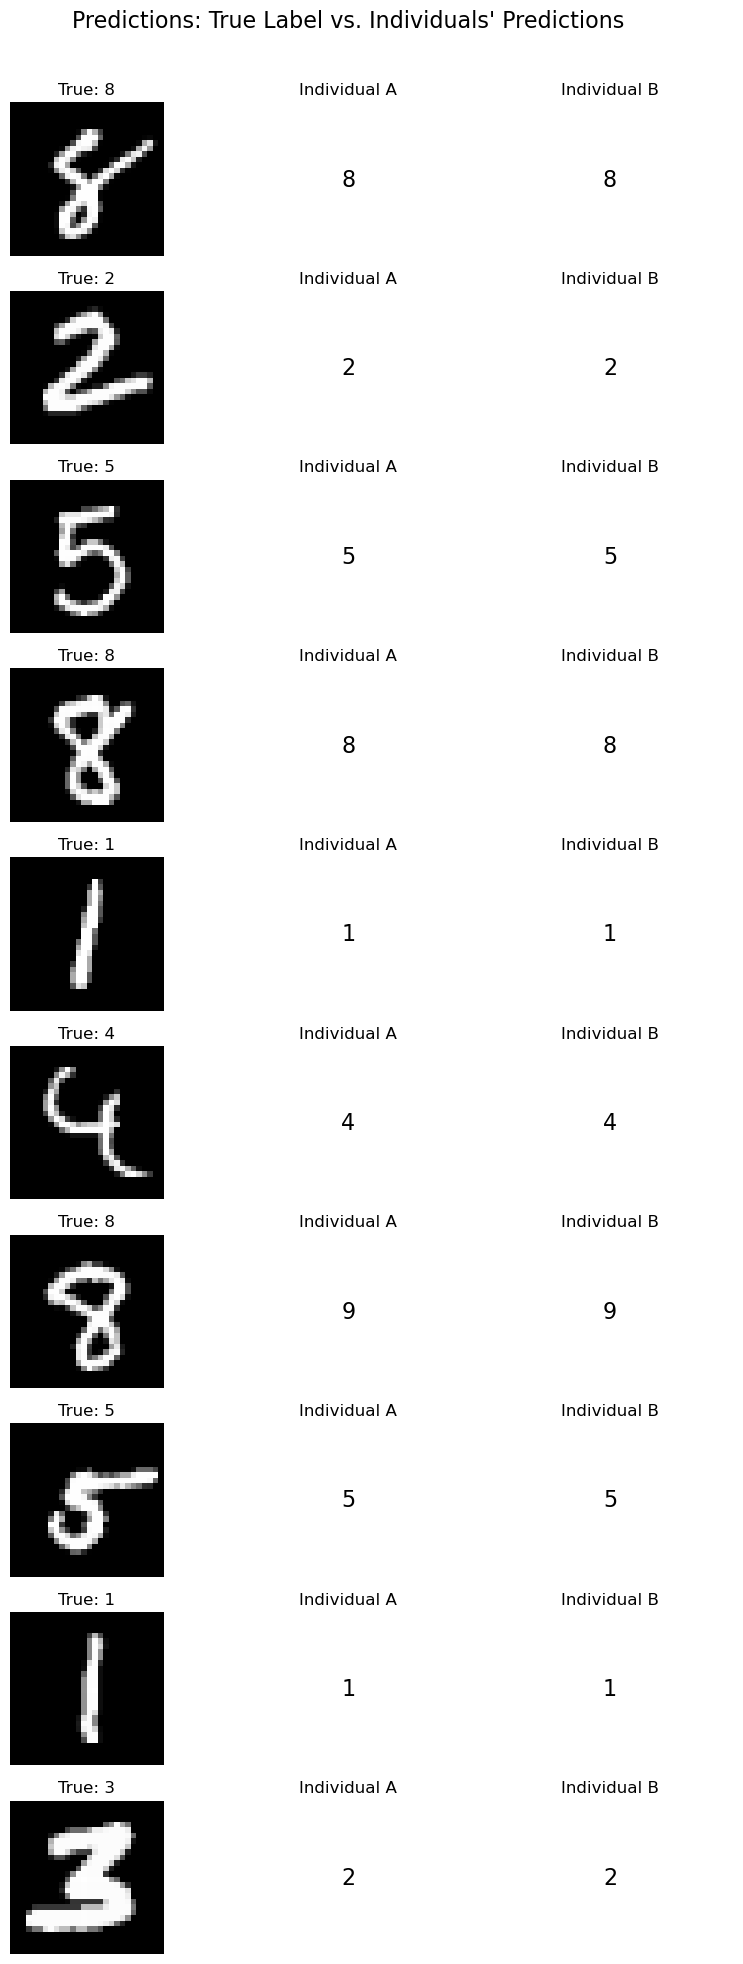

In [35]:
import matplotlib.pyplot as plt
import random
import torch

def visualize_predictions_on_random_samples(X_val_exp, y_val, original_images, individual_A, individual_B, model, n=10):
    """
    Visualize n random samples from the validation/test set using predictions
    from two candidate individuals.
    
    Args:
      X_val_exp (Tensor): Expanded validation features (shape: [N, 7850]).
      y_val (Tensor): True labels (shape: [N]).
      original_images (Tensor): Original validation images with bias removed 
                                (shape: [N, 785]), where first 784 values are the image.
      individual_A (Tensor): Candidate weight vector A (shape: [7850]).
      individual_B (Tensor): Candidate weight vector B (shape: [7850]).
      model: Instance of MultiClassLogisticRegressionWrapper.
      n (int): Number of random samples to display.
    """
    # Use X_val_exp's size (not X_val) to sample indices.
    indices = random.sample(range(X_val_exp.size(0)), n)

    # Create a grid of subplots.
    fig, axs = plt.subplots(n, 3, figsize=(8, n * 2))
    fig.suptitle("Predictions: True Label vs. Individuals' Predictions", fontsize=16)

    for i, idx in enumerate(indices):
        # Get the expanded input for candidate prediction (shape: (1, 7850)).
        x = X_val_exp[idx].unsqueeze(0)
        
        # For visualization: use the original image (remove bias column) and reshape to 28x28.
        img = original_images[idx].view(28, 28)
        true_label = int(y_val[idx].item())

        # Predict with Individual A using the candidate weight vector.
        scores_A = model.score_with(x, individual_A)  # shape: (1, 10)
        pred_A = torch.argmax(scores_A, dim=1).item()

        # Predict with Individual B using the candidate weight vector.
        scores_B = model.score_with(x, individual_B)
        pred_B = torch.argmax(scores_B, dim=1).item()

        # Plot the original image with true label.
        axs[i, 0].imshow(img, cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f"True: {true_label}")

        # Display Individual A's prediction.
        axs[i, 1].text(0.5, 0.5, f"{pred_A}", fontsize=16, ha='center', va='center')
        axs[i, 1].axis('off')
        axs[i, 1].set_title("Individual A")

        # Display Individual B's prediction.
        axs[i, 2].text(0.5, 0.5, f"{pred_B}", fontsize=16, ha='center', va='center')
        axs[i, 2].axis('off')
        axs[i, 2].set_title("Individual B")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# --- Example usage ---
# Assume you have defined `find_most_diverse_pair` function:
def find_most_diverse_pair(population):
    max_dist = 0
    pair = (None, None)
    for i in range(len(population)):
        for j in range(i + 1, len(population)):
            dist = torch.norm(population[i] - population[j])
            if dist > max_dist:
                max_dist = dist
                pair = (population[i], population[j])
    return pair

# Get the two most diverse individuals from your optimizer's population.
indiv_A, indiv_B = find_most_diverse_pair(optimizer.population)

# For visualization, remove the bias column from X_test.
original_val_images = X_test[:, :-1]  # shape: (N_test, 784)

# Now call the visualization function with your test set.
visualize_predictions_on_random_samples(X_test_exp, y_test, original_val_images, indiv_A, indiv_B, model, n=10)

In [36]:
import itertools
import torch

# This cell finds the best 3 individuals (by their indices in the population)
# such that when we perform majority voting over their predictions, we get
# the highest accuracy on (for example) the training set.

# Ensure that X_train_exp and y_train are on the same device as your model.
# For the majority voting computation we will move predictions to CPU.
device = X_train_exp.device

best_acc = 0.0
best_combo = None  # Will hold tuple of (index, candidate) for the best trio.

# Loop over all combinations of 3 individuals.
for combo in itertools.combinations(list(enumerate(optimizer.population)), 3):
    # combo is a tuple of three items: (index, candidate_tensor)
    # Extract the candidate weight vectors.
    candidates = [cand for (_, cand) in combo]
    
    # Compute predictions for each candidate over the whole dataset.
    pop_predictions = []
    for candidate in candidates:
        # Use model.score_with to compute scores with the candidate weight vector.
        # This returns a tensor of shape (N_samples, 10)
        scores = model.score_with(X_train_exp, candidate)
        preds = torch.argmax(scores, dim=1)  # shape: (N_samples,)
        pop_predictions.append(preds.unsqueeze(0))  # add a new dimension
    
    # Stack predictions into a tensor of shape (3, N_samples)
    pop_preds_tensor = torch.cat(pop_predictions, dim=0)
    
    # Compute majority vote along the first dimension.
    # (Move to CPU because torch.mode isn't implemented on MPS; then move back if needed.)
    majority_preds, _ = torch.mode(pop_preds_tensor.cpu(), dim=0)
    majority_preds = majority_preds.to(device)
    
    # Calculate the accuracy for this combination.
    acc = (majority_preds == y_train).float().mean().item() * 100
    
    # If this combination's accuracy is the best we've seen, store it.
    if acc > best_acc:
        best_acc = acc
        best_combo = combo

# Now, print the results.
if best_combo is not None:
    # best_combo contains tuples: (index, candidate) for each of the three.
    best_indices = [index for (index, _) in best_combo]
    print("Best trio indices:", best_indices)
    print("Majority vote accuracy with these three individuals: {:.2f}%".format(best_acc))
else:
    print("No valid combination found.")

Best trio indices: [21, 30, 36]
Majority vote accuracy with these three individuals: 81.38%


In [32]:
mse = torch.mean((indiv_A - indiv_B) ** 2)
print(f"MSE between indiv_A and indiv_B: {mse.item()}")

MSE between indiv_A and indiv_B: 19.937002182006836


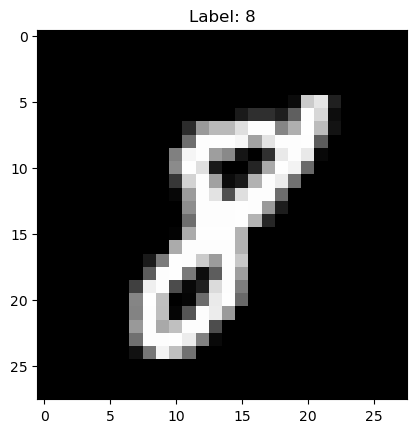

In [59]:
idx = 17
img = X_train[idx]  # Get the first image
plt.imshow(img[:-1].view(28, 28), cmap='gray')  # Exclude the bias term (last column)
plt.title(f"Label: {y_train[idx].item()}")  # Show the corresponding label
plt.show()